In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

df_crashes=pd.read_csv("cpd_crashes.csv")
df_crashes['date'] = pd.to_datetime(df_crashes['date'])
df_crashes.set_index('date', inplace=True)

print(df_crashes.head(5))

            cpd_crashes
date                   
2024-01-01           62
2024-01-02           69
2024-01-03           79
2024-01-04           73
2024-01-05           87


## Section 1 - Train and Test Splits


1. Based on the visual analysis, the test set may not be perfectly representative of the training set. 
2. The slight difference in level and the potential downward trend in the test set.


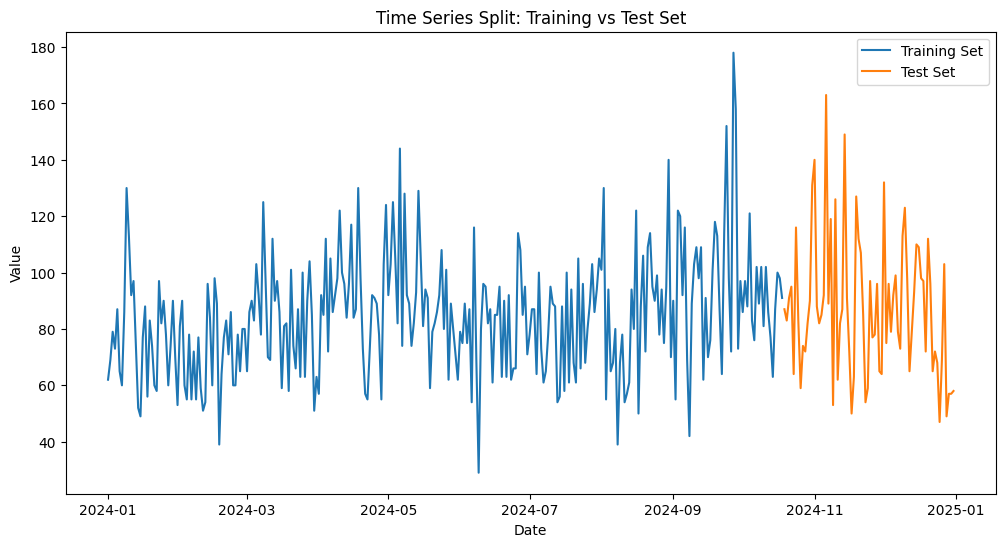

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your time series data is in a DataFrame called 'df' with a datetime index
total_observations = len(df_crashes)
train_size = int(0.8 * total_observations)

train_data = df_crashes[:train_size]
test_data = df_crashes[train_size:]

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Set')
plt.plot(test_data.index, test_data, label='Test Set')
plt.title('Time Series Split: Training vs Test Set')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## Section 2 - Cross-Validation Scheme

1. Initial Train_size = 146  # Initial training size (approximately 4 months)
2. Test size = 7

In [4]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the rolling window cross-validation
n_splits = 5  # Number of splits
initial_train_size = 146  # Initial training size (approximately 4 months)

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=7, gap=0)

In [6]:
for i, (train_index, val_index) in enumerate(tscv.split(train_data)):
    cv_train = train_data.iloc[train_index]
    cv_val = train_data.iloc[val_index]

    print(cv_val)

            cpd_crashes
date                   
2024-09-14           62
2024-09-15           91
2024-09-16           70
2024-09-17           76
2024-09-18          101
2024-09-19          118
2024-09-20          113
            cpd_crashes
date                   
2024-09-21           87
2024-09-22           64
2024-09-23          114
2024-09-24          152
2024-09-25           98
2024-09-26           72
2024-09-27          178
            cpd_crashes
date                   
2024-09-28          158
2024-09-29           73
2024-09-30           97
2024-10-01           86
2024-10-02           97
2024-10-03           88
2024-10-04          121
            cpd_crashes
date                   
2024-10-05           83
2024-10-06           76
2024-10-07          102
2024-10-08           89
2024-10-09          102
2024-10-10           81
2024-10-11          102
            cpd_crashes
date                   
2024-10-12           86
2024-10-13           77
2024-10-14           63
2024-10-15      

## Section 3 - Model Selection and Comparison

1- The numerical metrics clearly favor the SARIMA model.

- The SARIMA model shows approximately 30% improvement in RMSE and MAE compared to the Seasonal Naive model.
- The SARIMA model's MASE being less than 1 indicates it performs better than the average naive forecast.

2- Using 7-day forecast ,the visualizations are mixed. In some folds, ASRIMA seems better. In others, the Naive model captures specific short-term movements more accurately. However, overall, SARIMA seems to provide a more consistent, though smoother, forecast

C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\siddh\AppData\Local\Packages\PythonSoftwar

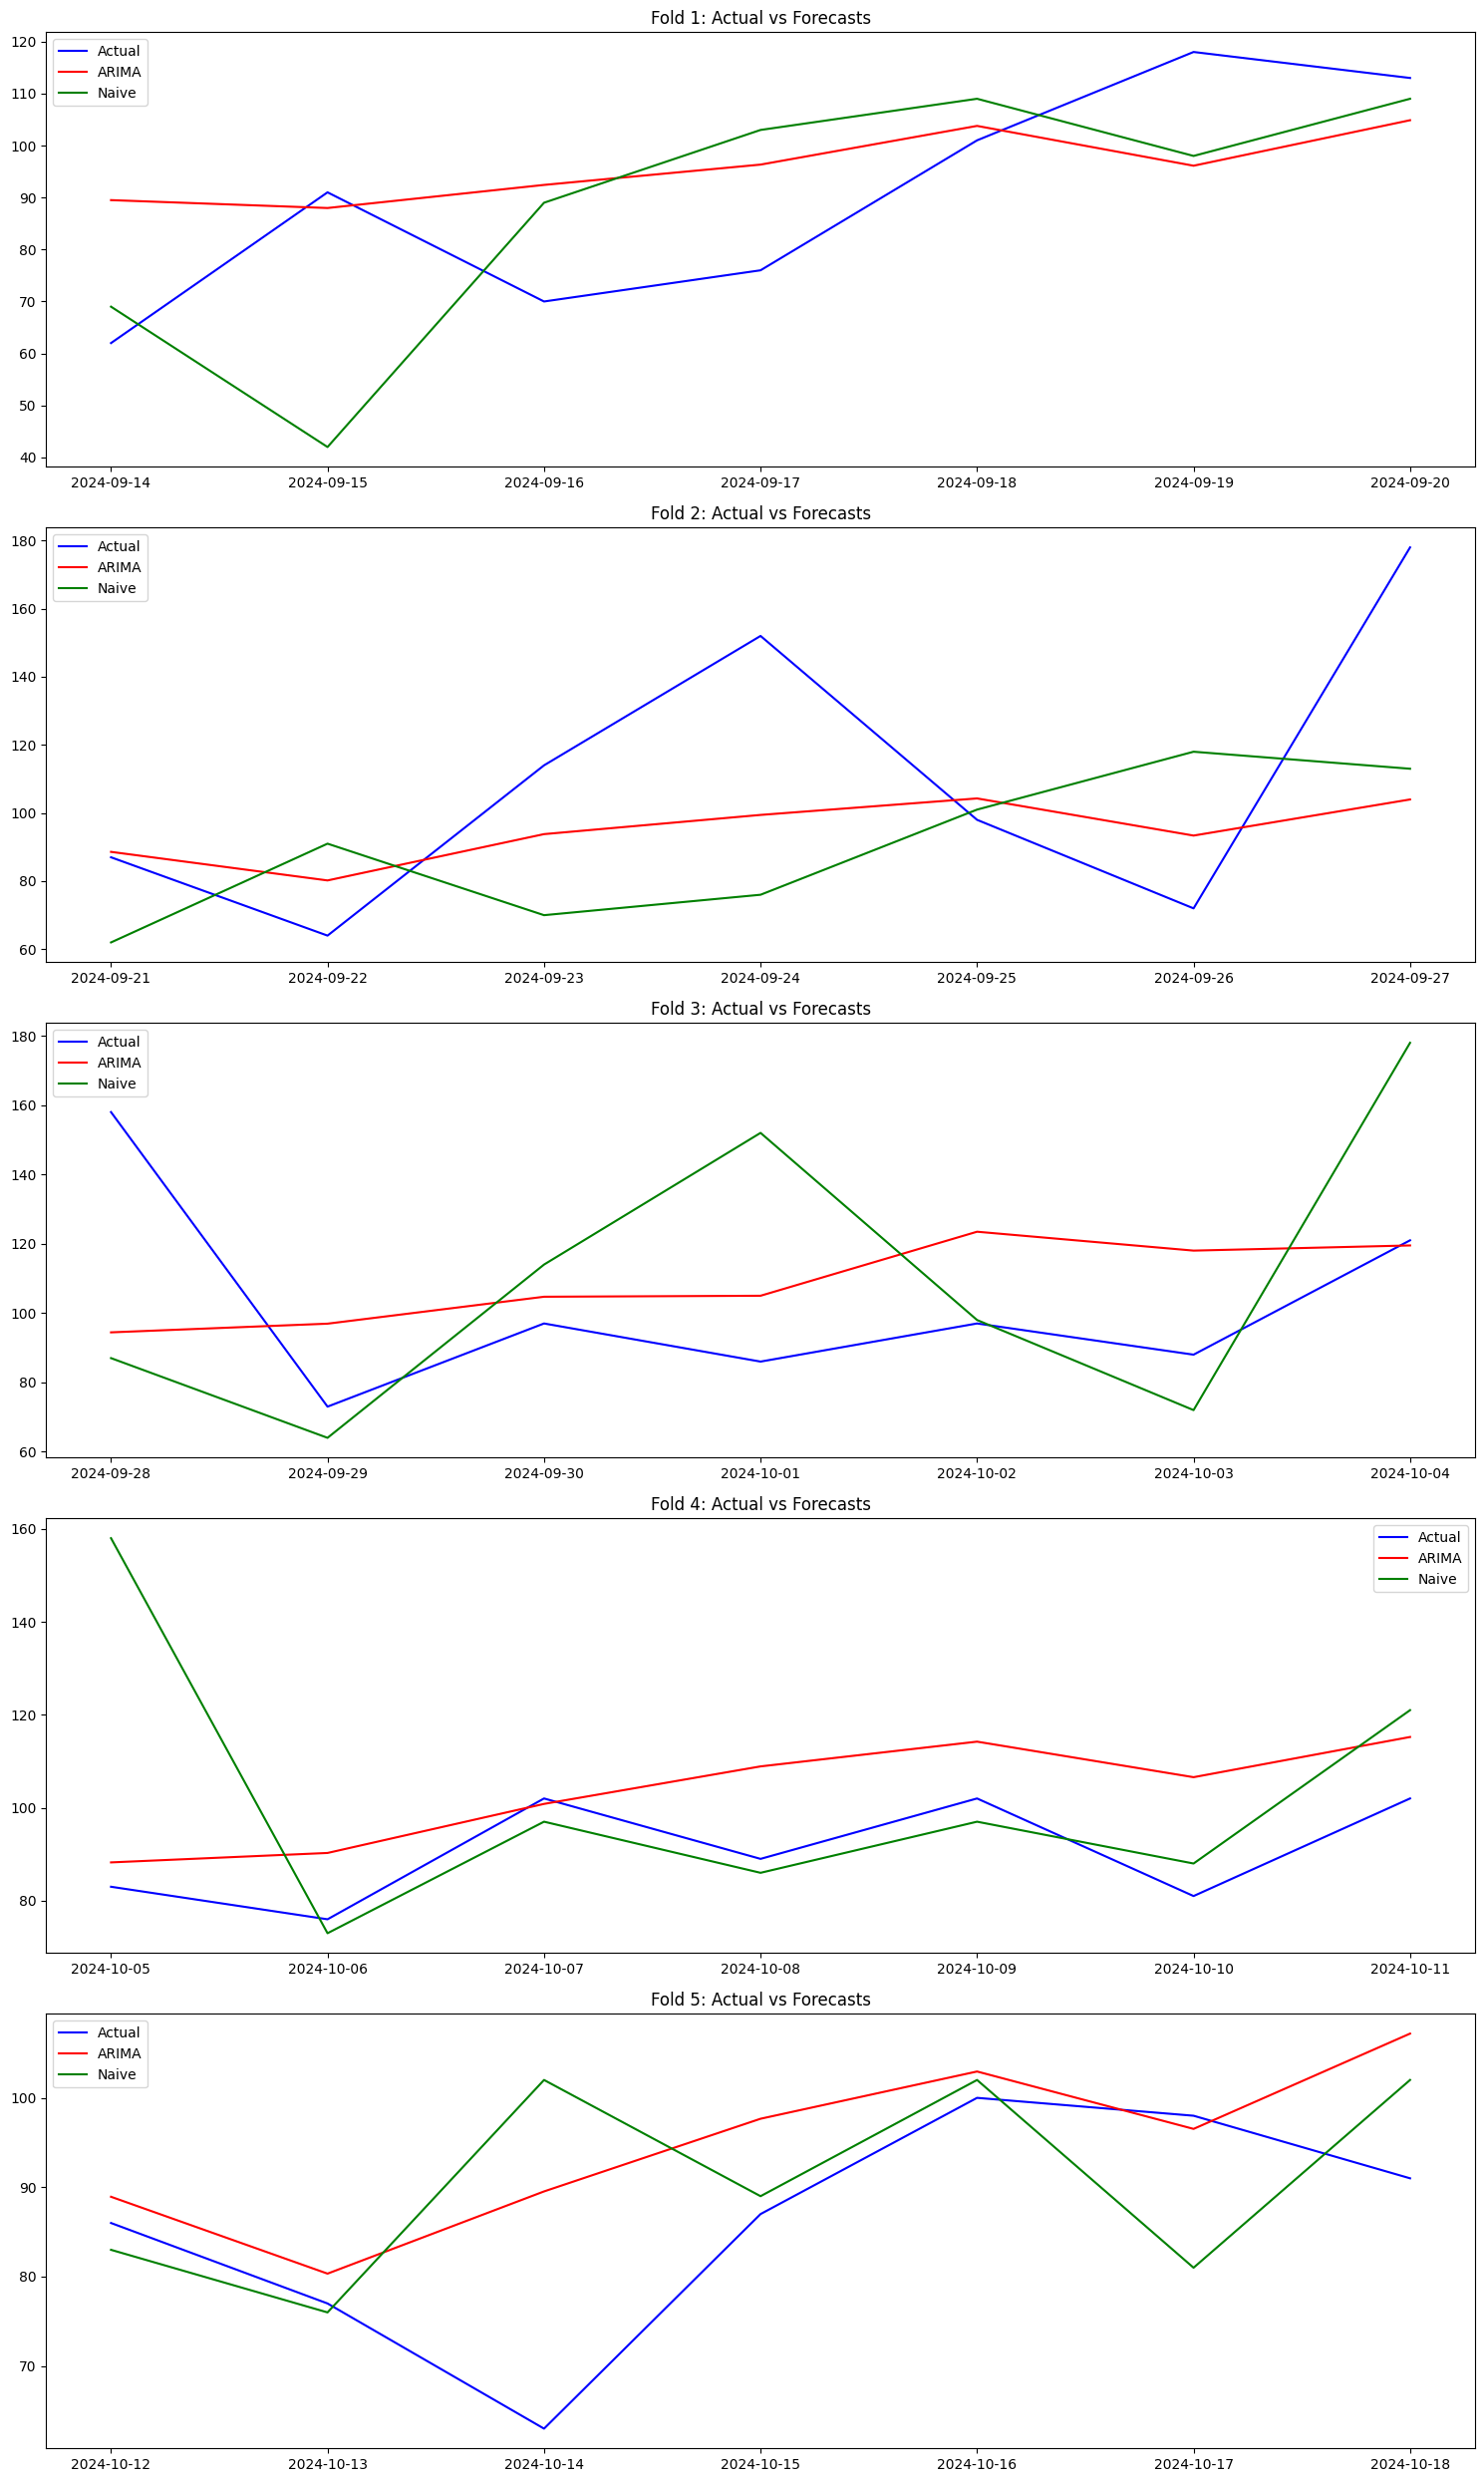

Metric     ARIMA  Seasonal Naive
  RMSE 22.614574       32.130181
   MAE 17.890912       24.257143
  MAPE 18.493401       24.921032
  MASE  0.838842        1.138106


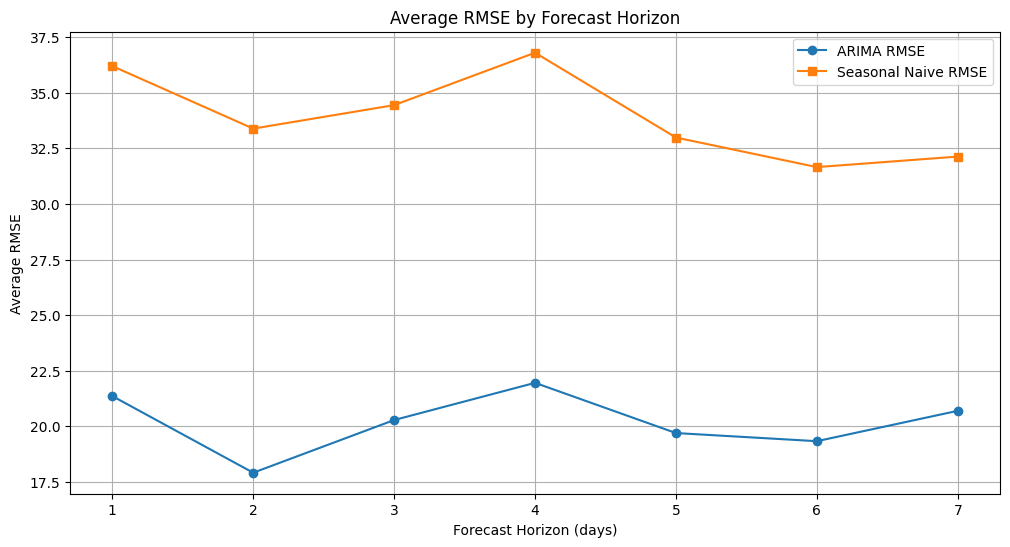

In [ ]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.abs(np.diff(y_train)).sum() / (n - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

# ARIMA order
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 7)

# Lists to store results
metrics = ['RMSE', 'MAE', 'MAPE', 'MASE']
arima_metrics = {metric: [] for metric in metrics}
naive_metrics = {metric: [] for metric in metrics}

plt.figure(figsize=(15, 5*n_splits))

for i, (train_index, val_index) in enumerate(tscv.split(train_data)):
    cv_train = train_data.iloc[train_index]
    cv_val = train_data.iloc[val_index]

    print(cv_train)
    
    # ARIMA forecast
    model = SARIMAX(cv_train['cpd_crashes'], order=order, seasonal_order=seasonal_order)
    results = model.fit()
    arima_forecast = results.forecast(steps=len(cv_val))
    
    # Seasonal Naive forecast
    seasonal_period = 7
    naive_forecast = cv_train['cpd_crashes'].iloc[-seasonal_period:].tolist() * (len(cv_val) // seasonal_period + 1)
    naive_forecast = naive_forecast[:len(cv_val)]
    
    # Calculate metrics
    for metric in metrics:
        if metric == 'RMSE':
            arima_metrics[metric].append(rmse(cv_val['cpd_crashes'], arima_forecast))
            naive_metrics[metric].append(rmse(cv_val['cpd_crashes'], naive_forecast))
        elif metric == 'MAE':
            arima_metrics[metric].append(mean_absolute_error(cv_val['cpd_crashes'], arima_forecast))
            naive_metrics[metric].append(mean_absolute_error(cv_val['cpd_crashes'], naive_forecast))
        elif metric == 'MAPE':
            arima_metrics[metric].append(mean_absolute_percentage_error(cv_val['cpd_crashes'], arima_forecast))
            naive_metrics[metric].append(mean_absolute_percentage_error(cv_val['cpd_crashes'], naive_forecast))
        elif metric == 'MASE':
            arima_metrics[metric].append(mean_absolute_scaled_error(cv_val['cpd_crashes'], arima_forecast, cv_train['cpd_crashes']))
            naive_metrics[metric].append(mean_absolute_scaled_error(cv_val['cpd_crashes'], naive_forecast, cv_train['cpd_crashes']))
    
    # Plot
    plt.subplot(n_splits, 1, i+1)
    plt.plot(cv_val.index, cv_val['cpd_crashes'], label='Actual', color='blue')
    plt.plot(cv_val.index, arima_forecast, label='ARIMA', color='red')
    plt.plot(cv_val.index, naive_forecast, label='Naive', color='green')
    plt.title(f'Fold {i+1}: Actual vs Forecasts')
    plt.legend()

plt.tight_layout()
plt.show()

# Create a table of average results
results_df = pd.DataFrame({
    'Metric': metrics,
    'ARIMA': [np.mean(arima_metrics[m]) for m in metrics],
    'Seasonal Naive': [np.mean(naive_metrics[m]) for m in metrics]
})
print(results_df.to_string(index=False))

# Visualize performance across forecast horizons
forecast_horizons = range(1, 8)  # 7-day forecast
arima_rmse = [np.mean([rmse(train_data.iloc[val_index]['cpd_crashes'][:i], 
                            results.forecast(steps=len(val_index))[:i]) 
                       for _, val_index in tscv.split(train_data)]) 
              for i in forecast_horizons]
naive_rmse = [np.mean([rmse(train_data.iloc[val_index]['cpd_crashes'][:i], 
                            train_data.iloc[train_index]['cpd_crashes'].iloc[-7:].tolist()[:i]) 
                       for train_index, val_index in tscv.split(train_data)]) 
              for i in forecast_horizons]

plt.figure(figsize=(12, 6))
plt.plot(forecast_horizons, arima_rmse, label='ARIMA RMSE', marker='o')
plt.plot(forecast_horizons, naive_rmse, label='Seasonal Naive RMSE', marker='s')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Average RMSE')
plt.title('Average RMSE by Forecast Horizon')
plt.legend()
plt.grid(True)
plt.show()

## Section 4 - Findings

1. SARIMA forecast struggles to get to the higher range of the value.
2. However, it does perform better than the naive models, as shown by the metrics.

**Because the SARIMA model is missing the peaks of the models, this can be construed as a model that is underfitting**

C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\siddh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\siddh\AppData\Local\Packages\PythonSoftwar

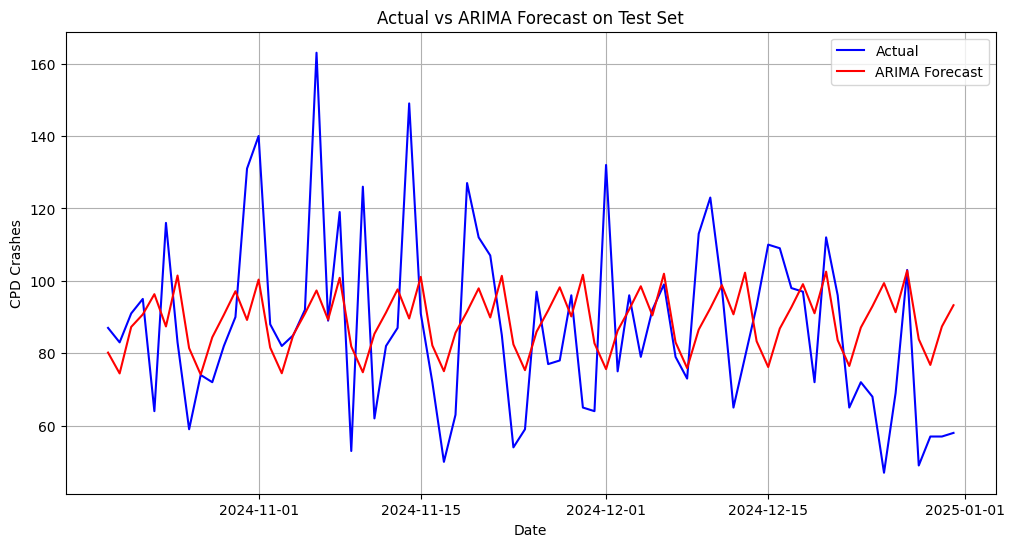

RMSE: 24.048060
MAE: 18.783916
MAPE: 23.219003
MASE: 0.874160


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse

# Assuming you have train_data and test_data DataFrames
# with 'cpd_crashes' as the target variable

# ARIMA order from previous analysis
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 7)

# Fit ARIMA model on entire training set
model = SARIMAX(train_data['cpd_crashes'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Forecast for the test set
forecast = results.forecast(steps=len(test_data))

# Visualize actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['cpd_crashes'], label='Actual', color='blue')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.title('Actual vs ARIMA Forecast on Test Set')
plt.xlabel('Date')
plt.ylabel('CPD Crashes')
plt.legend()
plt.grid(True)
plt.show()

# Calculate performance metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.abs(np.diff(y_train)).sum() / (n - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d

metrics = {
    'RMSE': rmse(test_data['cpd_crashes'], forecast),
    'MAE': mean_absolute_error(test_data['cpd_crashes'], forecast),
    'MAPE': mean_absolute_percentage_error(test_data['cpd_crashes'], forecast),
    'MASE': mean_absolute_scaled_error(test_data['cpd_crashes'], forecast, train_data['cpd_crashes'])
}

# Print performance metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.6f}")
